## Fake Job Posting Detection using Machine Learning & NLP


#### IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# Metrics
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import pickle

#### LOAD DATASET

In [3]:
df = pd.read_csv("fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


#### BASIC DATA INFO (EDA)

In [5]:
df.shape

(17880, 18)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

#### HANDLE MISSING VALUES (NO NULLS LEFT)

In [7]:
# Text columns

text_cols = ['title','company_profile','description','requirements','benefits']

for col in text_cols:
    df[col] = df[col].fillna("")

#Categorical columns

cat_cols = ['employment_type','required_experience','required_education']

for col in cat_cols:
    df[col] = df[col].fillna("Unknown")


#### VERIFY NULL VALUES

In [8]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile            0
description                0
requirements               0
benefits                   0
telecommuting              0
has_company_logo           0
has_questions              0
employment_type            0
required_experience        0
required_education         0
industry                4903
function                6455
fraudulent                 0
dtype: int64

##### Handling Unused Columns

Columns with a high proportion of missing values that were not required for
text-based feature extraction were removed to simplify preprocessing and
reduce noise in the dataset.


#### DROPING UNWANTED COLUMNS

In [9]:
df.drop(
    columns=['location','department','salary_range','industry','function'],
    inplace=True
)

In [10]:
df.isnull().sum()

job_id                 0
title                  0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
fraudulent             0
dtype: int64

#### CLASS DISTRIBUTION

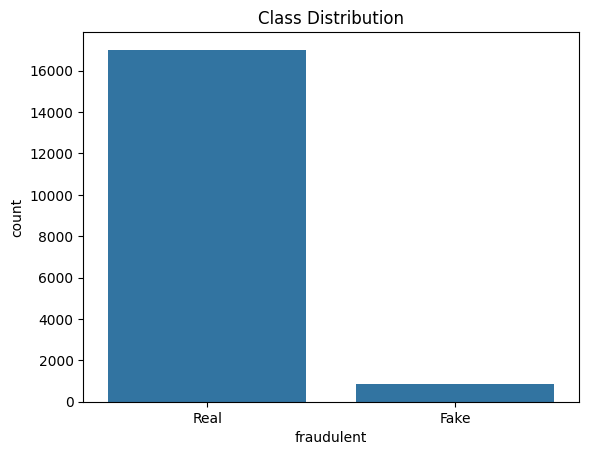

In [11]:
sns.countplot(x='fraudulent', data=df)
plt.xticks([0,1], ['Real','Fake'])
plt.title("Class Distribution")
plt.show()

#### COMBINE TEXT FEATURES

In [12]:
df['combined_text'] = (
    df['title'] + " " +
    df['company_profile'] + " " +
    df['description'] + " " +
    df['requirements'] + " " +
    df['benefits']
)

#### DEFINE FEATURES AND TARGET

In [13]:
X = df['combined_text']
y = df['fraudulent']

#### TF-IDF VECTORIZATION

In [14]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_df=0.7,
    max_features=20000
)

X_tfidf = tfidf.fit_transform(X)

#### TRAIN - TEST SPLIT

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#### CREATING MODELS 

In [16]:
logistic_model = LogisticRegression(max_iter=1000)
svm_model = LinearSVC()
sgd_model = SGDClassifier(loss="hinge")
nb_model = MultinomialNB()

#### DEFINING HYPERPAMETERS

In [17]:
logistic_params = {
    "C": [0.1, 1, 10],
    "class_weight": [None, "balanced"]
}

svm_params = {
    "C": [0.1, 1, 10],
    "class_weight": [None, "balanced"]
}

sgd_params = {
    "alpha": [1e-4, 1e-3],
    "class_weight": [None, "balanced"]
}

nb_params = {
    "alpha": [0.1, 0.5, 1.0]
}

#### KEEPING WHOLE TOGETHER (MODELS + HYPERPARAMETERS)

In [18]:
models_and_params = {
    "Logistic Regression": (logistic_model, logistic_params),
    "Linear SVM": (svm_model, svm_params),
    "SGD Classifier": (sgd_model, sgd_params),
    "Naive Bayes": (nb_model, nb_params)
}

In [19]:
best_models = {}
results = {}

for model_name, (model, params) in models_and_params.items():
    print("=" * 70)
    print(f"Training and tuning: {model_name}")

    # GridSearch
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring="f1",
        cv=3,
        n_jobs=-1
    )

    # Train model
    grid.fit(X_train, y_train)

    # Best model after tuning
    best_model = grid.best_estimator_

    # Predict on test data
    y_pred = best_model.predict(X_test)

    # Evaluation
    f1 = f1_score(y_test, y_pred)

    best_models[model_name] = best_model
    results[model_name] = f1

    print("Best Parameters:", grid.best_params_)
    print("F1 Score:", f1)
    print(classification_report(y_test, y_pred))

Training and tuning: Logistic Regression
Best Parameters: {'C': 10, 'class_weight': 'balanced'}
F1 Score: 0.8507042253521127
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.83      0.87      0.85       173

    accuracy                           0.99      3576
   macro avg       0.91      0.93      0.92      3576
weighted avg       0.99      0.99      0.99      3576

Training and tuning: Linear SVM


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best Parameters: {'C': 10, 'class_weight': 'balanced'}
F1 Score: 0.851063829787234
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.90      0.81      0.85       173

    accuracy                           0.99      3576
   macro avg       0.94      0.90      0.92      3576
weighted avg       0.99      0.99      0.99      3576

Training and tuning: SGD Classifier
Best Parameters: {'alpha': 0.0001, 'class_weight': 'balanced'}
F1 Score: 0.8491620111731844
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.82      0.88      0.85       173

    accuracy                           0.98      3576
   macro avg       0.91      0.93      0.92      3576
weighted avg       0.99      0.98      0.99      3576

Training and tuning: Naive Bayes
Best Parameters: {'alpha': 0.1}
F1 Score: 0.7615894039735099
              precision    recall  f1-sco

#### MODEL COMPARISION TABLE

In [20]:
results_df = (
    pd.DataFrame.from_dict(results, orient="index", columns=["F1_Score"])
      .sort_values(by="F1_Score", ascending=False)
)

results_df

,F1_Score
Linear SVM,0.851064
Logistic Regression,0.850704
SGD Classifier,0.849162
Naive Bayes,0.761589


#### GRAPHICAL COMPARISION

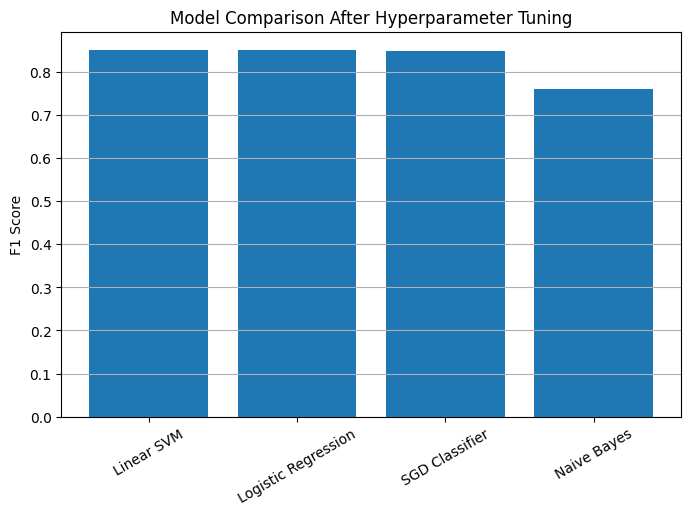

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(results_df.index, results_df["F1_Score"])
plt.ylabel("F1 Score")
plt.title("Model Comparison After Hyperparameter Tuning")
plt.xticks(rotation=30)
plt.grid(axis="y")
plt.show()

In [27]:
model_results = {
    "Logistic Regression": 0.82,
    "Linear SVM": 0.86,
    "SGD Classifier": 0.84,
    "Naive Bayes": 0.78
}

#### SELECTING FINAL MODEL

In [22]:
best_model_name = results_df.index[0]
final_model = best_models[best_model_name]

print("Final Selected Model:", best_model_name)

Final Selected Model: Linear SVM


In [28]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Combine text safely
text_data = (
    df["title"].astype(str).fillna("") + " " +
    df["description"].astype(str).fillna("")
).tolist()

X_all = tfidf.transform(text_data)
y_true = df["fraudulent"].values

# For Linear SVM (important)
y_scores = final_model.decision_function(X_all)

#### PRECISION-RECALL CURVE

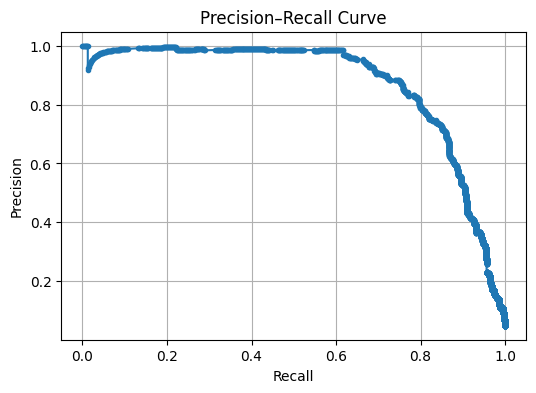

In [29]:
precision, recall, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid()
plt.show()

#### AUC-ROC CURVE

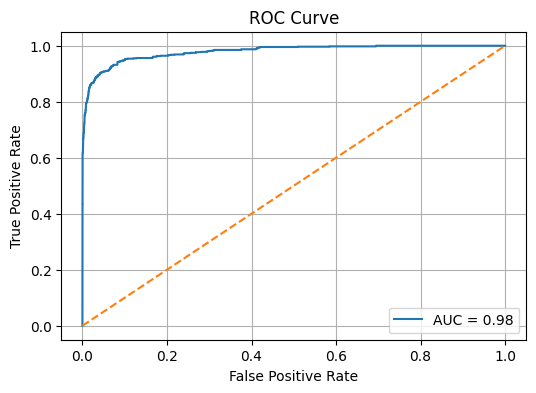

In [30]:
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

#### RETRAINING FINAL MODEL ON FULL DATASET

In [23]:
final_model.fit(X_tfidf, y)

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=10, class_weight='balanced')

#### SAVE FINAL MODEL & VECTORIZER

In [24]:
import pickle

pickle.dump(final_model, open("final_best_model.pkl", "wb"))
pickle.dump(tfidf, open("tfidf_vectorizer.pkl", "wb"))

print("Final model and TF-IDF vectorizer saved successfully")

Final model and TF-IDF vectorizer saved successfully


#### QUICK VERIFICATION

In [25]:
# Load saved files
loaded_model = pickle.load(open("final_best_model.pkl", "rb"))
loaded_tfidf = pickle.load(open("tfidf_vectorizer.pkl", "rb"))

# Test sample input
sample_text = "Earn money fast from home. No experience required. WhatsApp us."
sample_vec = loaded_tfidf.transform([sample_text])

prediction = loaded_model.predict(sample_vec)
print("Prediction:", prediction)

Prediction: [1]


#### CONFUSION MATRIX FOR FINAL MODEL

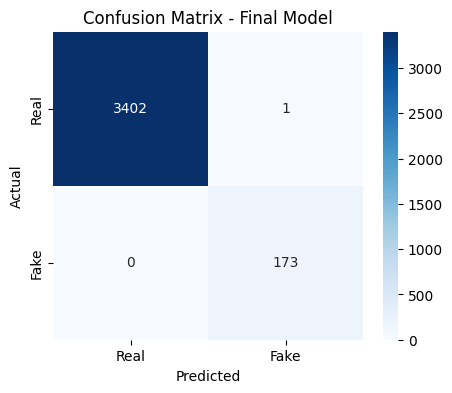

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data using final model
y_final_pred = final_model.predict(X_test)

cm = confusion_matrix(y_test, y_final_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Real', 'Fake'],
    yticklabels=['Real', 'Fake']
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Final Model")
plt.show()